In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyhepmc
import plotly.graph_objects as go
from DarkNews import GenLauncher

# HEPMC Plotter

This notebook takes in both DarkNews and TEG HEPMC outputs and turns them into a pandas dataframe for plotting

In [27]:
def hepmc_to_df(file):
    cols = ['Event', 'State','PDG', 'px', 'py', 'pz', 'E', 'vtx_x', 'vtx_y', 'vtx_z', 'vtx_t']
    # df_list = []  # Collect all event dataframes
    df = pd.DataFrame(columns=cols)
    with pyhepmc.open(file) as f:

        for event in f:
            event.set_units(pyhepmc.Units.MomentumUnit.GEV, pyhepmc.Units.LengthUnit.CM)
        
            # print(f"Event {event.event_number} uses units: Momentum - {units.momentum}, Length - {units.length}")
            
            status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr = [], [], [], [], [], [], [], [], [], []

            for particle in event.particles:
                # Get the vertex that produced this particle

                status_arr.append(particle.status)
                pdg_arr.append(particle.pid)

                try: 
                    vertex = particle.end_vertex.position
                except(AttributeError):
                    vertex =  particle.production_vertex.position

                vtx_x_arr.append(vertex[0])
                vtx_y_arr.append(vertex[1])
                vtx_z_arr.append(vertex[2])
                vtx_t_arr.append(vertex[3])

                momentum = particle.momentum
                px_arr.append(momentum[0])
                py_arr.append(momentum[1])
                pz_arr.append(momentum[2])
                E_arr.append(momentum[3])

            interaction = np.array([status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr]).T
            temp_df = pd.DataFrame(interaction, columns=cols[1:])
            temp_df.insert(0, 'Event', event.event_number)    
            df = pd.concat([df, temp_df], ignore_index=True)

    return df

def get_opening_angle(df, pdg1, pdg2):
    angles = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        particle1 = group[group['PDG'] == pdg1]
        particle2 = group[group['PDG'] == pdg2]
        if not particle1.empty and not particle2.empty:
            p1 = np.array([particle1.iloc[0]['px'], particle1.iloc[0]['py'], particle1.iloc[0]['pz']])
            p2 = np.array([particle2.iloc[0]['px'], particle2.iloc[0]['py'], particle2.iloc[0]['pz']])
            cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
            angles.append(np.degrees(angle))  # Convert to degrees
    return angles

def get_two_body_inv_mass(df, pdg1, pdg2):
    inv_masses = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        particle1 = group[group['PDG'] == pdg1]
        particle2 = group[group['PDG'] == pdg2]
        if not particle1.empty and not particle2.empty:
            E1 = particle1.iloc[0]['E']
            E2 = particle2.iloc[0]['E']
            p1 = np.array([particle1.iloc[0]['px'], particle1.iloc[0]['py'], particle1.iloc[0]['pz']])
            p2 = np.array([particle2.iloc[0]['px'], particle2.iloc[0]['py'], particle2.iloc[0]['pz']])
            total_E = E1 + E2
            total_p = p1 + p2
            inv_mass = np.sqrt(total_E**2 - np.dot(total_p, total_p))
            inv_masses.append(inv_mass)
    return inv_masses

def get_lead_shower_energy(df):
    shower_energy = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        group = group[group['PDG'].abs() == 11] # e+ or e-
        if len(group) > 1:
            group = group.iloc[group['E'].argmax()]
        elif len(group) == 0:
            continue

        shower_energy.append(group['E'])
    return shower_energy

In [28]:
make_new_dn = False
mzprime = 0.15
m4 = 0.6

kwargs = {  
        'neval': 1e3,
        'HNLtype': 'dirac',
        'hepmc3': True,
        # 'hepevt': True,
        'unweighted_hep_events': 100,
        # 'hep_unweight': True,
        'experiment': 'microboone',
        'nopelastic': True,
        'pandas': False,
        'loglevel': 'WARNING'
        }

if make_new_dn:
    gen_object = GenLauncher(mzprime=mzprime, m4=m4,**kwargs)
    gen_object.run(overwrite_path='./')
    dn_df = gen_object.df

In [29]:

file = 'outputs/numu_epem_5000.hepmc' # Large TEG sample
trident_epem = hepmc_to_df(file)

file = 'hep_ascii.hepmc3'
dn_epem = hepmc_to_df(file)

file = 'outputs/0.001_0.1_epem.hepmc' # Le-Lmu sample, mzprime=0.1 GeV, gprime=0.001
lelmu_epem = hepmc_to_df(file)

/tmp/ipykernel_3332215/1255370945.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)
/tmp/ipykernel_3332215/1255370945.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)
/tmp/ipykernel_3332215/1255370945.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determinin

In [30]:
trident_angles = get_opening_angle(trident_epem, 11, -11)
dn_angles = get_opening_angle(dn_epem, 11, -11)
lelmu_angles = get_opening_angle(lelmu_epem, 11, -11)

trident_inv_masses = get_two_body_inv_mass(trident_epem, 11, -11)
dn_inv_masses = get_two_body_inv_mass(dn_epem, 11, -11)
lelmu_inv_masses = get_two_body_inv_mass(lelmu_epem, 11, -11)

# Opening Angle

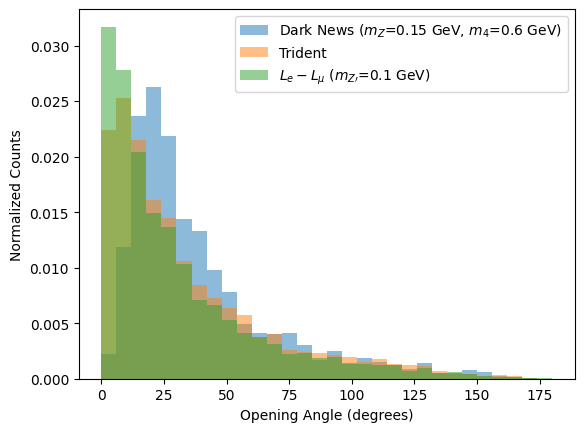

In [37]:
bins = np.linspace(0, 180, 31)
plt.hist(dn_angles, bins=bins, alpha=0.5, density=True, label=r'Dark News ($m_Z$=0.15 GeV, $m_4$=0.6 GeV)')
plt.hist(trident_angles, bins=bins, alpha=0.5, density=True, label='Trident')
plt.hist(lelmu_angles, bins=bins, alpha=0.5, density=True, label=r'$L_e-L_\mu$ ($m_{Z\prime}$=0.1 GeV)')

plt.legend()
plt.xlabel('Opening Angle (degrees)')
plt.ylabel('Normalized Counts')
# plt.title('Comparison of e+e- Opening Angles')
plt.show()

# Invariant Mass

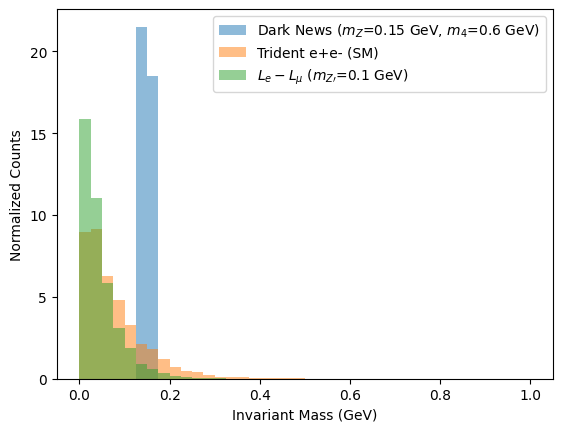

In [39]:
bins = np.linspace(0, 1, 41)
plt.hist(dn_inv_masses, bins=bins, alpha=0.5, density=True, label=r'Dark News ($m_Z$=0.15 GeV, $m_4$=0.6 GeV)')
plt.hist(trident_inv_masses, bins=bins, alpha=0.5, density=True, label='Trident e+e- (SM)')
plt.hist(lelmu_inv_masses, bins=bins, alpha=0.5, density=True, label=r'$L_e-L_\mu$ ($m_{Z\prime}$=0.1 GeV)')
plt.legend()
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

# Lead Shower Energy

In [206]:
trident_shower_energy = get_lead_shower_energy(trident_epem)
dn_shower_energy = get_lead_shower_energy(dn_epem)

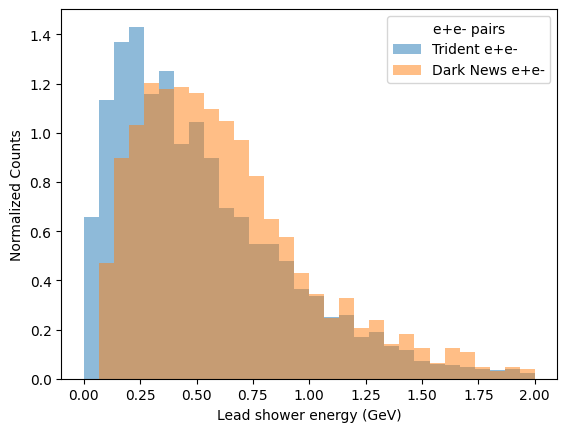

In [267]:
bins = np.linspace(0, 2, 31)
plt.hist(trident_shower_energy, bins=bins, alpha=0.5, density=True, label='Trident e+e-')
plt.hist(dn_shower_energy, bins=bins, alpha=0.5, density=True, label='Dark News e+e-')
plt.legend(title='e+e- pairs')
plt.xlabel('Lead shower energy (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

# 2D Momentum Distributions

In [226]:
    
def get_shower_pair_energies(df):
    query = 'State == 1 & (PDG == 11 | PDG == -11)'

    df.query(query).groupby('Event')

    shower_energy_pairs = []

    for event_no, group in df.query(query).groupby('Event'):
        showers = group['E'].sort_values().values
        shower_energy_pairs.append(showers)
    return np.array(shower_energy_pairs)

trident_showers = get_shower_pair_energies(trident_epem)
dn_showers = get_shower_pair_energies(dn_epem)


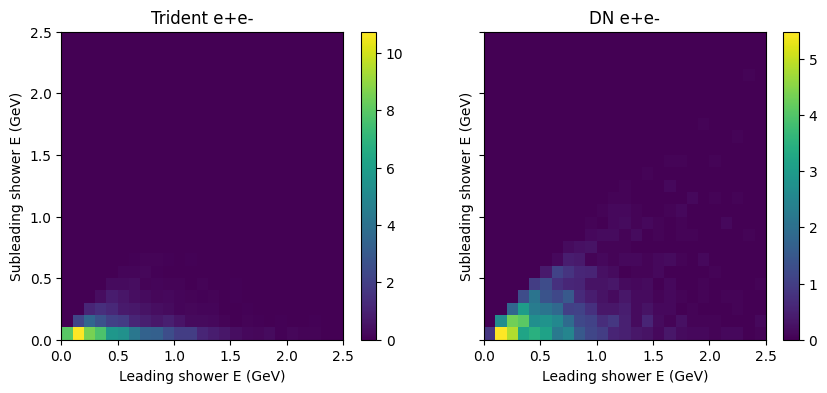

In [258]:


E_bins = np.linspace(0, 2.5, 26)
fig, ax = plt.subplots(1,2,  sharex=True, sharey=True,figsize = (10,4))

plt.sca(ax[0])
arr = trident_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
plt.ylabel('Subleading shower E (GeV)')
plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title('Trident e+e-')

plt.sca(ax[1])
arr = dn_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
plt.ylabel('Subleading shower E (GeV)')
plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title('DN e+e-')
plt.show()
